In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import mat73
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

from scipy.signal import find_peaks
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import r2_score
import psutil
import os
import time

In [ ]:
wandb.login()
run = wandb.init(project="master-multicomponent-mri", name="3d-cnn-baseline-fullpatch-attention-2")

wandb: Currently logged in as: tr-phan (trphan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
data = mat73.loadmat('../../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat')
input_noisy_np = data['input_noisy']
input_clean_np = data['input']
ref_np = data['ref']

print("Shape of input data:", input_noisy_np.shape)
print("Shape of reference data:", ref_np.shape)

Shape of input data: (9, 9, 8, 47932)
Shape of reference data: (9, 9, 32, 47932)


In [4]:
nan_count_input_noisy_before = np.isnan(input_noisy_np).sum()
nan_count_ref_before = np.isnan(ref_np).sum()
print(f"NaN count in input_noisy before handling: {nan_count_input_noisy_before}")
print(f"NaN count in ref before handling: {nan_count_ref_before}")

NaN count in input_noisy before handling: 1635840
NaN count in ref before handling: 0


In [5]:
input_noisy_np = np.nan_to_num(input_noisy_np, nan=0.0)
nan_count_input_noisy_after = np.isnan(input_noisy_np).sum()
print(f"NaN count in input_noisy after handling: {nan_count_input_noisy_after}")

NaN count in input_noisy after handling: 0


In [6]:
class T1PatchDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

In [7]:
class SpatialAttention3D(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention3D, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv3d(in_channels, in_channels//8, kernel_size=1),
            nn.BatchNorm3d(in_channels//8),
            nn.LeakyReLU(0.1),
            nn.Conv3d(in_channels//8, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

In [ ]:
class CNN3DWithAttention(nn.Module):
    def __init__(self):
        super(CNN3DWithAttention, self).__init__()
        
        self.conv1 = nn.Conv3d(1, 64, kernel_size=(3,3,3), padding=(1,1,1))
        self.bn1 = nn.BatchNorm3d(64)
        self.relu1 = nn.LeakyReLU(0.1)
        self.attention1 = SpatialAttention3D(64)
        
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3,3,3), padding=(1,1,1))
        self.bn2 = nn.BatchNorm3d(128)
        self.relu2 = nn.LeakyReLU(0.1)
        self.attention2 = SpatialAttention3D(128)
        
        self.conv3 = nn.Conv3d(128, 256, kernel_size=(3,3,3), padding=(1,1,1))
        self.bn3 = nn.BatchNorm3d(256)
        self.relu3 = nn.LeakyReLU(0.1)
        self.attention3 = SpatialAttention3D(256)
        
        self.final_conv = nn.Conv3d(256, 32, kernel_size=(8,1,1))
        
    def forward(self, x):
        # Add channel dimension
        x = x.unsqueeze(1)
        
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.attention1(x)
        
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.attention2(x)
        
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.attention3(x)
        
        x = self.final_conv(x)
        
        # Remove extra dimension
        x = x.squeeze(2)
        
        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-6, path='saved_models/best_3dcnn_model_att_2.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [ ]:
# Transpose the input and reference data to be (N, C, H, W) format
input_noisy_torch = np.transpose(input_noisy_np, (3, 2, 0, 1))
ref_torch = np.transpose(ref_np, (3, 2, 0, 1))

input_noisy_torch = torch.tensor(input_noisy_torch, dtype=torch.float32)
ref_torch = torch.tensor(ref_torch, dtype=torch.float32)

In [ ]:
# Create Dataset
dataset = T1PatchDataset(input_noisy_torch, ref_torch)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN3DWithAttention().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)
early_stopping = EarlyStopping(patience=6, path='best_3dcnn_model.pt')

num_epochs = 50

d:\Proton Drive\My files\Schule\Master\Masterarbeit\project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
# Log configuration
wandb.config.update({
    "learning_rate": 0.001,
    "batch_size": batch_size,
    "epochs": num_epochs,
    "architecture": "3DCNN",
    "optimizer": "Adam",
    "loss_function": "MSELoss",
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": 6
})

In [14]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Training')
    
    for inputs, targets in progress_bar_train:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        progress_bar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation')
    
    with torch.no_grad():
        for inputs, targets in progress_bar_val:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            progress_bar_val.set_postfix({'loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Early stopping
    early_stopping(avg_val_loss, model)

    # Logging
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": current_lr
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, LR: {current_lr}')

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("Training finished")

Epoch [1/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.88it/s, loss=0.00247]


Epoch [1/50], Train Loss: 0.004915321367637565, Val Loss: 0.0029342793642232814, LR: 0.001


Epoch [2/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.98it/s, loss=0.00226]


Epoch [2/50], Train Loss: 0.0026559312853108473, Val Loss: 0.0026185718815152845, LR: 0.001


Epoch [3/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.39it/s, loss=0.00194]


Epoch [3/50], Train Loss: 0.0023570011323317884, Val Loss: 0.0022391990556692083, LR: 0.001


Epoch [4/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.30it/s, loss=0.00181]


Epoch [4/50], Train Loss: 0.002248404749358694, Val Loss: 0.002175804196546475, LR: 0.001


Epoch [5/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.49it/s, loss=0.00187]


Epoch [5/50], Train Loss: 0.002162769621160502, Val Loss: 0.002069473173469305, LR: 0.001


Epoch [6/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 53.73it/s, loss=0.00184]


EarlyStopping counter: 1 out of 15
Epoch [6/50], Train Loss: 0.0021146340099706625, Val Loss: 0.002103963514479498, LR: 0.001


Epoch [7/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 55.12it/s, loss=0.00184]


Epoch [7/50], Train Loss: 0.002074658433169437, Val Loss: 0.0020631579868495464, LR: 0.001


Epoch [8/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 57.51it/s, loss=0.0018] 


Epoch [8/50], Train Loss: 0.002050076286153247, Val Loss: 0.0020211274875327947, LR: 0.001


Epoch [9/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 55.32it/s, loss=0.00177]


Epoch [9/50], Train Loss: 0.0020275789132574574, Val Loss: 0.0019987700670026243, LR: 0.001


Epoch [10/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 57.44it/s, loss=0.00175]


Epoch [10/50], Train Loss: 0.0019996182814550896, Val Loss: 0.0019770777241016426, LR: 0.001


Epoch [11/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 57.19it/s, loss=0.00181]


EarlyStopping counter: 1 out of 15
Epoch [11/50], Train Loss: 0.001993363936392901, Val Loss: 0.0019857742901270587, LR: 0.001


Epoch [12/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.12it/s, loss=0.00178]


Epoch [12/50], Train Loss: 0.0019734900237138695, Val Loss: 0.001940779658810546, LR: 0.001


Epoch [13/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 59.02it/s, loss=0.00173]


EarlyStopping counter: 1 out of 15
Epoch [13/50], Train Loss: 0.0019635557332852234, Val Loss: 0.0019415687544581792, LR: 0.001


Epoch [14/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.69it/s, loss=0.0017] 


Epoch [14/50], Train Loss: 0.001945717272659143, Val Loss: 0.0019254395885703465, LR: 0.001


Epoch [15/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.45it/s, loss=0.00183]


EarlyStopping counter: 1 out of 15
Epoch [15/50], Train Loss: 0.0019397830674036717, Val Loss: 0.0020539472298696636, LR: 0.001


Epoch [16/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.67it/s, loss=0.00169]


Epoch [16/50], Train Loss: 0.0019218989255993316, Val Loss: 0.0019099555870828529, LR: 0.001


Epoch [17/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.02it/s, loss=0.00172]


EarlyStopping counter: 1 out of 15
Epoch [17/50], Train Loss: 0.001917858994274866, Val Loss: 0.0019150004854115348, LR: 0.001


Epoch [18/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.32it/s, loss=0.00178]


EarlyStopping counter: 2 out of 15
Epoch [18/50], Train Loss: 0.0019022825703723357, Val Loss: 0.0019410787126980722, LR: 0.001


Epoch [19/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 59.70it/s, loss=0.00166]


Epoch [19/50], Train Loss: 0.0018951293707747633, Val Loss: 0.0018711265246383847, LR: 0.001


Epoch [20/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 57.50it/s, loss=0.00164]


Epoch [20/50], Train Loss: 0.0018848809733754024, Val Loss: 0.0018612245361631116, LR: 0.001


Epoch [21/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 55.17it/s, loss=0.00166]


Epoch [21/50], Train Loss: 0.0018791205569868908, Val Loss: 0.001844587278707574, LR: 0.001


Epoch [22/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 57.78it/s, loss=0.00171]


EarlyStopping counter: 1 out of 15
Epoch [22/50], Train Loss: 0.001869923227156202, Val Loss: 0.0019114905339665711, LR: 0.001


Epoch [23/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.13it/s, loss=0.00162]


EarlyStopping counter: 2 out of 15
Epoch [23/50], Train Loss: 0.0018656670870647455, Val Loss: 0.0018492411977301042, LR: 0.001


Epoch [24/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 61.53it/s, loss=0.00164]


Epoch [24/50], Train Loss: 0.00185466566181276, Val Loss: 0.0018332341065009435, LR: 0.001


Epoch [25/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.06it/s, loss=0.00166]


EarlyStopping counter: 1 out of 15
Epoch [25/50], Train Loss: 0.001849322134706502, Val Loss: 0.0018582112745692333, LR: 0.001


Epoch [26/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 55.34it/s, loss=0.00167]


EarlyStopping counter: 2 out of 15
Epoch [26/50], Train Loss: 0.0018415083687674874, Val Loss: 0.0018427327601239086, LR: 0.001


Epoch [27/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 54.98it/s, loss=0.0017] 


EarlyStopping counter: 3 out of 15
Epoch [27/50], Train Loss: 0.0018347530645163109, Val Loss: 0.0018529399678421518, LR: 0.001


Epoch [28/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 57.08it/s, loss=0.00162]


Epoch [28/50], Train Loss: 0.0018324033522124712, Val Loss: 0.0018064312761028607, LR: 0.001


Epoch [29/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 56.70it/s, loss=0.00164]


EarlyStopping counter: 1 out of 15
Epoch [29/50], Train Loss: 0.0018237389608596762, Val Loss: 0.0018131512791539231, LR: 0.001


Epoch [30/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 56.56it/s, loss=0.00166]


EarlyStopping counter: 2 out of 15
Epoch [30/50], Train Loss: 0.0018184950798361872, Val Loss: 0.0018187098399115105, LR: 0.001


Epoch [31/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 60.12it/s, loss=0.00169]


EarlyStopping counter: 3 out of 15
Epoch [31/50], Train Loss: 0.0018155005407364418, Val Loss: 0.0018745304457843304, LR: 0.001


Epoch [32/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 61.62it/s, loss=0.00163]


Epoch [32/50], Train Loss: 0.0018127774802269413, Val Loss: 0.0018029457028023899, LR: 0.001


Epoch [33/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 61.92it/s, loss=0.00162]


Epoch [33/50], Train Loss: 0.001802819229196757, Val Loss: 0.0017994214276162287, LR: 0.001


Epoch [34/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.94it/s, loss=0.00169]


EarlyStopping counter: 1 out of 15
Epoch [34/50], Train Loss: 0.001801587989126953, Val Loss: 0.001825775858014822, LR: 0.001


Epoch [35/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 54.83it/s, loss=0.00159]


EarlyStopping counter: 2 out of 15
Epoch [35/50], Train Loss: 0.0017946108907926828, Val Loss: 0.0018017323641106486, LR: 0.001


Epoch [36/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.95it/s, loss=0.00166]


EarlyStopping counter: 3 out of 15
Epoch [36/50], Train Loss: 0.001792237796083403, Val Loss: 0.0018272424590153, LR: 0.001


Epoch [37/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 61.92it/s, loss=0.00174]


EarlyStopping counter: 4 out of 15
Epoch [37/50], Train Loss: 0.00179554011595125, Val Loss: 0.0018430409634796281, LR: 0.001


Epoch [38/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.63it/s, loss=0.00163]


Epoch [38/50], Train Loss: 0.0017850785256208232, Val Loss: 0.0017978220960746208, LR: 0.001


Epoch [39/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.73it/s, loss=0.00164]


EarlyStopping counter: 1 out of 15
Epoch [39/50], Train Loss: 0.0017797732826632757, Val Loss: 0.001824165500390033, LR: 0.001


Epoch [40/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.07it/s, loss=0.00175]


EarlyStopping counter: 2 out of 15
Epoch [40/50], Train Loss: 0.00177787218359299, Val Loss: 0.0018792518701714774, LR: 0.001


Epoch [41/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 61.19it/s, loss=0.00181]


EarlyStopping counter: 3 out of 15
Epoch [41/50], Train Loss: 0.0017763517354615033, Val Loss: 0.0019290329647871356, LR: 0.001


Epoch [42/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 61.56it/s, loss=0.0016] 


Epoch [42/50], Train Loss: 0.00177063784271013, Val Loss: 0.0017828629678115248, LR: 0.001


Epoch [43/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.10it/s, loss=0.00169]


EarlyStopping counter: 1 out of 15
Epoch [43/50], Train Loss: 0.001767469637755615, Val Loss: 0.001809643463542064, LR: 0.001


Epoch [44/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 58.37it/s, loss=0.00163]


EarlyStopping counter: 2 out of 15
Epoch [44/50], Train Loss: 0.0017633118589098255, Val Loss: 0.0018697962537407875, LR: 0.001


Epoch [45/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.40it/s, loss=0.00159]


EarlyStopping counter: 3 out of 15
Epoch [45/50], Train Loss: 0.0017627890095657979, Val Loss: 0.0017928791403149565, LR: 0.001


Epoch [46/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.52it/s, loss=0.00159]


EarlyStopping counter: 4 out of 15
Epoch [46/50], Train Loss: 0.00175853442614122, Val Loss: 0.0017862096754834055, LR: 0.001


Epoch [47/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.27it/s, loss=0.00162]


EarlyStopping counter: 5 out of 15
Epoch [47/50], Train Loss: 0.0017523145052837207, Val Loss: 0.0018098376031654576, LR: 0.0005


Epoch [48/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.09it/s, loss=0.00161]


EarlyStopping counter: 6 out of 15
Epoch [48/50], Train Loss: 0.0017204926488921047, Val Loss: 0.0018189923178094129, LR: 0.0005


Epoch [49/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 63.05it/s, loss=0.00158]


EarlyStopping counter: 7 out of 15
Epoch [49/50], Train Loss: 0.0017158794853215417, Val Loss: 0.0017839915677905084, LR: 0.0005


Epoch [50/50] Validation: 100%|██████████| 150/150 [00:02<00:00, 62.51it/s, loss=0.00157]


Epoch [50/50], Train Loss: 0.0017126879214386765, Val Loss: 0.0017736524196031193, LR: 0.0005
Training finished


In [ ]:
#model.load_state_dict(torch.load('saved_models/best_3dcnn_model.pt'))
# model.eval()

In [ ]:
def calculate_psnr(target, prediction):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((target - prediction) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(target)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_peak_metrics_patch(target, prediction, prominence=0.1):
    """Calculate peak detection accuracy for full patch predictions"""
    peak_metrics = {'true_peaks': 0, 'predicted_peaks': 0, 'matching_peaks': 0}
    
    # Iterate over each voxel in the patch
    batch_size, num_points, height, width = target.shape
    
    for b in range(batch_size):
        for h in range(height):
            for w in range(width):
                # Get spectrum for current voxel
                true_spectrum = target[b, :, h, w]
                pred_spectrum = prediction[b, :, h, w]
                
                # Find peaks
                true_peaks, _ = find_peaks(true_spectrum, prominence=prominence)
                pred_peaks, _ = find_peaks(pred_spectrum, prominence=prominence)
                
                # Count matching peaks
                matches = 0
                for tp in true_peaks:
                    for pp in pred_peaks:
                        if abs(tp - pp) <= 1:
                            matches += 1
                            break
                
                peak_metrics['true_peaks'] += len(true_peaks)
                peak_metrics['predicted_peaks'] += len(pred_peaks)
                peak_metrics['matching_peaks'] += matches
    
    return peak_metrics

def measure_inference_time(model, input_tensor, device, num_iterations=100):
    """Measure average inference time"""
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_tensor.to(device))
    end_time = time.time()
    return (end_time - start_time) / num_iterations

def count_parameters(model):
    """Count number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_memory_usage():
    """Measure current memory usage"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

def calculate_spatial_consistency(targets, predictions, window_size=3):
    """Calculate spatial consistency metric with proper handling of constant patches"""
    batch_size, num_points, height, width = targets.shape
    consistency_scores = []
    
    # Calculate local spatial correlation for each patch
    for b in range(min(batch_size, 100)):  # Limit to 100 samples for efficiency
        for t in range(num_points):
            true_patch = targets[b, t]
            pred_patch = predictions[b, t]
            
            # Skip if either patch is constant
            if np.std(true_patch) == 0 or np.std(pred_patch) == 0:
                continue
                
            # Calculate local spatial correlation
            try:
                correlation = np.corrcoef(true_patch.flatten(), pred_patch.flatten())[0, 1]
                if not np.isnan(correlation):
                    consistency_scores.append(correlation)
            except:
                continue
    
    # Return mean if we have scores, otherwise return 0
    return np.mean(consistency_scores) if consistency_scores else 0.0


def evaluate_model_metrics(model, val_loader, device):
    """Evaluate all model metrics for patch-based models"""
    model.eval()
    metrics = {}
    
    # Get sample input for inference time measurement
    sample_input, _ = next(iter(val_loader))
    metrics['inference_time'] = measure_inference_time(model, sample_input, device)
    
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            # Convert to numpy for metric calculation
            targets_np = targets.cpu().numpy()
            outputs_np = outputs.cpu().numpy()
            
            all_targets.append(targets_np)
            all_predictions.append(outputs_np)
    
    # Concatenate all batches
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    
    # Calculate metrics
    metrics['mse'] = np.mean((all_targets - all_predictions) ** 2)
    metrics['mae'] = np.mean(np.abs(all_targets - all_predictions))
    metrics['psnr'] = calculate_psnr(all_targets, all_predictions)
    
    # Calculate R² score for each spatial position
    r2_scores = []
    batch_size, num_points, height, width = all_targets.shape
    for h in range(height):
        for w in range(width):
            true_spectra = all_targets[:, :, h, w].reshape(-1)
            pred_spectra = all_predictions[:, :, h, w].reshape(-1)
            r2_scores.append(r2_score(true_spectra, pred_spectra))
    metrics['r2_score'] = np.mean(r2_scores)
    
    # Calculate peak metrics for patches
    metrics['peak_metrics'] = calculate_peak_metrics_patch(all_targets, all_predictions)
    
    # System metrics
    metrics['memory_usage'] = measure_memory_usage()
    metrics['num_parameters'] = count_parameters(model)
    
    # Add spatial metrics
    metrics['spatial_consistency'] = calculate_spatial_consistency(all_targets, all_predictions)
    
    return metrics

In [ ]:
model.eval()
final_metrics = evaluate_model_metrics(model, val_loader, device)

wandb.log({
    "final_mse": final_metrics['mse'],
    "final_mae": final_metrics['mae'],
    "final_psnr": final_metrics['psnr'],
    "final_r2_score": final_metrics['r2_score'],
    "peak_detection_accuracy": final_metrics['peak_metrics']['matching_peaks'] / 
                             final_metrics['peak_metrics']['true_peaks'],
    "inference_time_ms": final_metrics['inference_time'] * 1000,
    "memory_usage_mb": final_metrics['memory_usage'],
    "model_parameters": final_metrics['num_parameters']
})

print("\nFinal Model Evaluation:")
print(f"MSE: {final_metrics['mse']:.6f}")
print(f"MAE: {final_metrics['mae']:.6f}")
print(f"PSNR: {final_metrics['psnr']:.2f} dB")
print(f"R² Score: {final_metrics['r2_score']:.4f}")
print(f"Peak Detection Accuracy: {final_metrics['peak_metrics']['matching_peaks'] / final_metrics['peak_metrics']['true_peaks']:.2%}")
print(f"Average Inference Time: {final_metrics['inference_time']*1000:.2f} ms")
print(f"Memory Usage: {final_metrics['memory_usage']:.1f} MB")
print(f"Number of Parameters: {final_metrics['num_parameters']:,}")


Final Model Evaluation:
MSE: 0.001774
MAE: 0.022189
PSNR: 27.48 dB
R² Score: 0.5661
Peak Detection Accuracy: 41.51%
Average Inference Time: 15.91 ms
Memory Usage: 2719.3 MB
Number of Parameters: 1,196,680


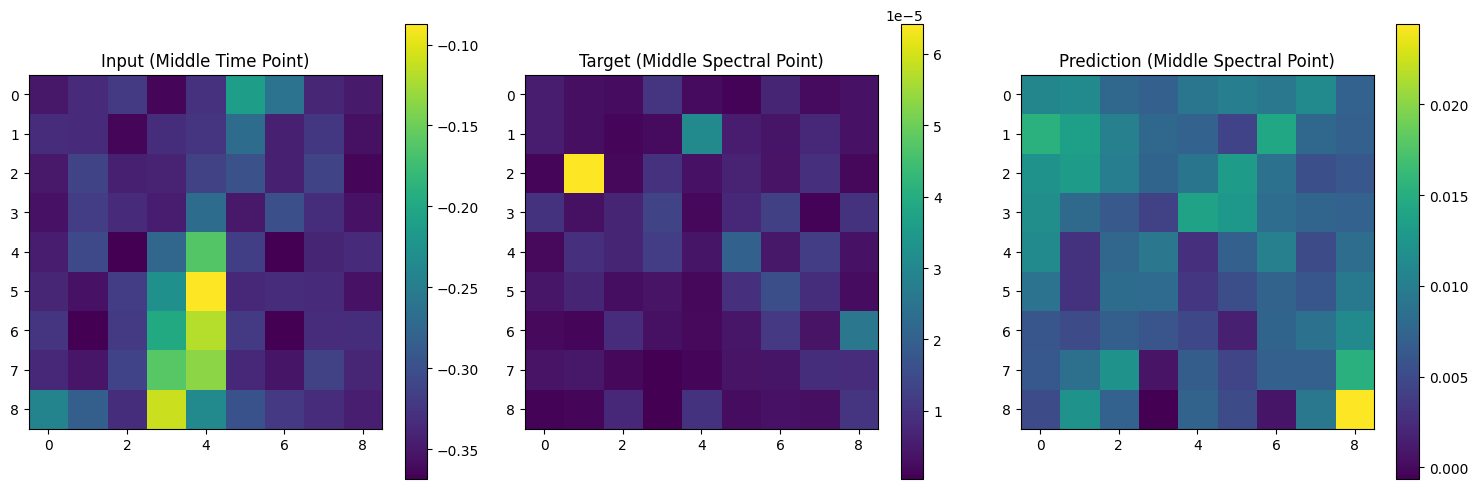

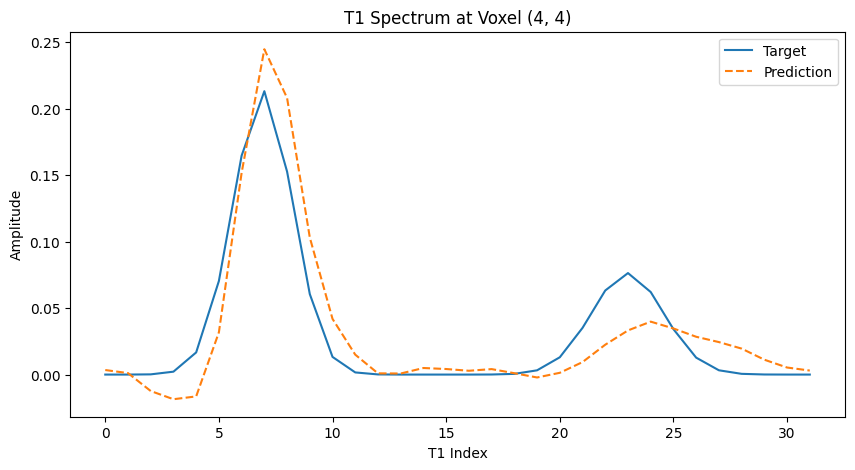

Example MSE: 0.000531
Example MAE: 0.013631


In [ ]:
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

with torch.no_grad():
    outputs = model(inputs)

inputs = inputs.cpu().numpy()
targets = targets.cpu().numpy()
outputs = outputs.cpu().numpy()

example_idx = 0

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(inputs[example_idx, 4, :, :])  # Middle temporal slice (4 out of 8)
plt.title('Input (Middle Time Point)')
plt.colorbar()

plt.subplot(132)
plt.imshow(targets[example_idx, 16, :, :])  # Middle spectral point (16 out of 32)
plt.title('Target (Middle Spectral Point)')
plt.colorbar()

plt.subplot(133)
plt.imshow(outputs[example_idx, 16, :, :])  # Middle spectral point
plt.title('Prediction (Middle Spectral Point)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Plot spectrum for a single voxel
voxel_x, voxel_y = 4, 4  # Middle voxel
plt.figure(figsize=(10, 5))
plt.plot(targets[example_idx, :, voxel_x, voxel_y], label='Target')
plt.plot(outputs[example_idx, :, voxel_x, voxel_y], '--', label='Prediction')
plt.title(f'T1 Spectrum at Voxel ({voxel_x}, {voxel_y})')
plt.xlabel('T1 Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

mse = np.mean((targets[example_idx] - outputs[example_idx])**2)
mae = np.mean(np.abs(targets[example_idx] - outputs[example_idx]))
print(f"Example MSE: {mse:.6f}")
print(f"Example MAE: {mae:.6f}")

In [19]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
final_mae,▁
final_mse,▁
final_psnr,▁
final_r2_score,▁
inference_time_ms,▁
learning_rate,█████████████████████████████████████▁▁▁
memory_usage_mb,▁
model_parameters,▁
peak_detection_accuracy,▁
train_loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
